In [2]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor

# Data storage
package_name = []
city_name = []
hotel_type = []
price1 = []
discounted_price = []
original_price = []
discount_amount = []
duration = []
rating = []
reviews = []

# Create a session to reuse connections
session = requests.Session()

for page_num in range(1, 22):  # Pages 1 to 22
    url = f"https://traveltriangle.com/tour-packages/india/page/{page_num}"
    
    try:
        page = session.get(url, timeout=10)
        soup = BeautifulSoup(page.text, "html.parser")

        # Extract package names
        package_name.extend([p.text.strip() if p.text.strip() else "NaN" for p in soup.find_all('span', class_="fw9 m0 f16 pfc3")])

        # Extract city names and clean them
        raw_cities = [i.text.strip() if i.text.strip() else "NaN" for i in soup.find_all('ul', class_='clearfix package-cities-list at_packagecity_list')]
        city_name.extend([re.split(r'\s*\(', city)[0] for city in raw_cities])

        # Extract hotel type (only first entry)
        for i in soup.find_all('div', class_="flex alignCenter"):
            hotel_text = i.text.strip()
            match = re.findall(r'\d\s*Star', hotel_text)
            hotel_type.append(match[0] if match else "NaN")

        # Extract pricing
        for p in soup.find_all('p', class_="sfc3 m0 f24 fw9 priceVal at_newprice"):
            price1.append(p.text.strip())

        # Extract duration
        duration.extend([int(i.text.strip().split()[0]) if i.text.strip() and i.text.strip()[0].isdigit() else "NaN" for i in soup.find_all('span', class_="iblock sfc6")])

        # Extract all the package links
        base_url = "https://traveltriangle.com"
        links = set()
        for div in soup.find_all('div', class_='clearfix row p8 bb radius2'):
            for a_tag in div.find_all('a', href=True):
                full_link = urljoin(base_url, a_tag['href'])
                links.add(full_link)

        # Fetch ratings & reviews concurrently
        def fetch_ratings_reviews(url_sub):
            try:
                response = session.get(url_sub, timeout=10)
                soup_rating = BeautifulSoup(response.text, "html.parser")
                rating_match = re.findall(r"Rated\s(\d+\.\d+)/5", soup_rating.text)
                rating_value = rating_match[0] if rating_match else "NaN"
                review_match = re.findall(r"\(based on (\d+)\sreviews\)", soup_rating.text)
                review_value = review_match[0] if review_match else "NaN"
                return rating_value, review_value
            except requests.RequestException:
                return "NaN", "NaN"

        with ThreadPoolExecutor(max_workers=5) as executor:
            results = list(executor.map(fetch_ratings_reviews, links))
        
        for rate, review in results:
            rating.append(rate)
            reviews.append(review)
    
    except requests.RequestException:
        print(f"Error fetching page {page_num}")

# Process price data
for price in price1:
    prices = re.findall(r'\d{1,3}(?:,\d{3})*', price)
    if len(prices) == 2:
        discounted_price.append(prices[0])
        original_price.append(prices[1])
        discount_amount.append(str(int(prices[1].replace(',', '')) - int(prices[0].replace(',', ''))))
    elif len(prices) == 1:
        discounted_price.append(prices[0])
        original_price.append("NaN")
        discount_amount.append("NaN")
    else:
        discounted_price.append("NaN")
        original_price.append("NaN")
        discount_amount.append("NaN")

# Print results
print("Package Names:", package_name)
print("City Names:", city_name)
print("Hotel Types:", hotel_type)
print("Discounted Prices:", discounted_price)
print("Original Prices:", original_price)
print("Discount Amount:", discount_amount)
print("Duration:", duration)
print("Ratings:", rating)
print("Reviews:", reviews)

Package Names: ['Most Reasonable Goa Honeymoon Tour Packages', 'Fantastic Andaman Honeymoon Package', 'Romantic Mussoorie Tour Package From Delhi', 'Coorg Package For 2 Nights And 3 Days', 'Best 4N 5D Andaman Sightseeing Tour Package For A Refreshing Getaway', 'Mesmerising Manali Trip Package From Chandigarh', 'Hills & Houseboat: Munnar and Alleppey Honeymoon Package', 'Top Family Holiday Packages in Goa for an Ideal Family Vacation', 'Most Affordable 1 Night 2 Days Uttarakhand Tour Packages From Delhi', 'Top 4 Nights 5 Days Best-Selling Sikkim Gangtok Darjeeling Tour Package', 'Best 5 Night 6 Day Leh Ladakh Tour Package For A Fun Filled Vacay', 'Postcard-Perfect Sikkim Gangtok Lachung Honeymoon Packages', 'Best Selling Kerala Houseboat & Jungle Safari Tour Package', 'Go on an excursion to Shillong to witness the best of natural attraction', 'Top 5 Nights 6 Days Kerala Family Tour Packages For A Refreshing Getaway', 'Exciting Goa Tour Packages For A Perfect Getaway', 'Discover Our Beau

In [4]:
print(len(package_name))
print(len(city_name))
print(len(hotel_type))
print(len(discounted_price))
print(len(original_price))
print(len(discount_amount))
print(len(duration))
print(len(rating))
print(len(reviews))

525
525
525
525
525
525
525
525
525


In [ ]:
##spare code

In [58]:
#code with the functions
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor

# Data storage
package_name = []
city_name = []
hotel_type = []
price1 = []
discounted_price = []
original_price = []
discount_amount = []
duration = []
rating = []
reviews = []

# Create a session to reuse connections
session = requests.Session()

def fetch_ratings_reviews(url_sub):
    """Fetch rating and review count from a single package link."""
    try:
        response = session.get(url_sub, timeout=10)
        soup_rating = BeautifulSoup(response.text, "html.parser")

        # Extract rating
        rating_match = re.findall(r"Rated\s(\d+\.\d+)/5", soup_rating.text)
        rating_value = rating_match[0] if rating_match else "NaN"

        # Extract review count
        review_match = re.findall(r"\(based on (\d+)\sreviews\)", soup_rating.text)
        review_value = review_match[0] if review_match else "NaN"

        return rating_value, review_value

    except requests.RequestException as e:
        print(f"Error fetching {url_sub}: {e}")
        return "NaN", "NaN"

def fetch_page_data(page_num):
    """Fetch and process the main page data."""
    url = f"https://traveltriangle.com/tour-packages/india/page/{page_num}"
    
    try:
        page = session.get(url, timeout=10)
        soup = BeautifulSoup(page.text, "html.parser")

        # Extract package names
        package_name.extend([p.text.strip() if p.text.strip() else "NaN" for p in soup.find_all('span', class_="fw9 m0 f16 pfc3")])

        # Extract city names and clean them
        raw_cities = [i.text.strip() if i.text.strip() else "NaN" for i in soup.find_all('ul', class_='clearfix package-cities-list at_packagecity_list')]
        city_name.extend([re.split(r'\s*\(', city)[0] for city in raw_cities])

        # Extract hotel type (only first entry)
        for i in soup.find_all('div', class_="flex alignCenter"):
            hotel_text = i.text.strip()
            match = re.findall(r'\d\s*Star', hotel_text)  # Extract first occurrence of "X Star"
            hotel_type.append(match[0] if match else "NaN")

        # Extract pricing
        for p in soup.find_all('p', class_="sfc3 m0 f24 fw9 priceVal at_newprice"):
            price1.append(p.text.strip())

        # Extract duration
        duration.extend([int(i.text.strip().split()[0]) if i.text.strip() and i.text.strip()[0].isdigit() else "NaN" for i in soup.find_all('span', class_="iblock sfc6")])


        # Extract all the package links
        base_url = "https://traveltriangle.com"
        links = set()  
        for div in soup.find_all('div', class_='clearfix row p8 bb radius2'):
            for a_tag in div.find_all('a', href=True):
                full_link = urljoin(base_url, a_tag['href'])
                links.add(full_link)

        # Use ThreadPoolExecutor to fetch ratings & reviews concurrently for all links
        with ThreadPoolExecutor(max_workers=5) as executor:
            results = list(executor.map(fetch_ratings_reviews, links))
        
        # Append the ratings and reviews to the lists
        for rate, review in results:
            rating.append(rate)
            reviews.append(review)

    except requests.RequestException as e:
        print(f"Error fetching page {page_num}: {e}")

# Scrape data from all pages
for i in range(1,22 ):  # Pages 1 to 22
    fetch_page_data(i)

# Clean and format price data
for price in price1:
    prices = re.findall(r'\d{1,3}(?:,\d{3})*', price)  # Extract all numbers in price format
    if len(prices) == 2:
        discounted_price.append(prices[0])  # First price as discounted
        original_price.append(prices[1])  # Second price as original
        discount_amount.append(str(int(prices[1].replace(',', '')) - int(prices[0].replace(',', ''))))  # Calculate difference
    elif len(prices) == 1:
        discounted_price.append(prices[0])  # If only one price, assume it's the discounted one
        original_price.append("NaN")  # No original price available
        discount_amount.append("NaN")  # No difference
    else:
        discounted_price.append("NaN")
        original_price.append("NaN")
        discount_amount.append("NaN")

# Ensure lists have the same length by filling missing values
max_length = max(len(package_name), len(city_name), len(hotel_type), len(discounted_price), len(original_price), len(duration), len(rating), len(reviews))

def pad_list(lst):
    return lst + ["NaN"] * (max_length - len(lst))

package_name = pad_list(package_name)
city_name = pad_list(city_name)
hotel_type = pad_list(hotel_type)
discounted_price = pad_list(discounted_price)
original_price = pad_list(original_price)
discount_amount = pad_list(discount_amount)
duration = pad_list(duration)
rating = pad_list(rating)
reviews = pad_list(reviews)

# Print the results
print("Package Names:", package_name)
print("City Names:", city_name)
print("Hotel Types:", hotel_type)
print("Discounted Prices:", discounted_price)
print("Original Prices:", original_price)
print("Discount Amount:", discount_amount)
print("Duration:", duration)
print("Ratings:", rating)
print("Reviews:", reviews)

Package Names: ['Most Reasonable Goa Honeymoon Tour Packages', 'Fantastic Andaman Honeymoon Package', 'Romantic Mussoorie Tour Package From Delhi', 'Coorg Package For 2 Nights And 3 Days', 'Best 4N 5D Andaman Sightseeing Tour Package For A Refreshing Getaway', 'Mesmerising Manali Trip Package From Chandigarh', 'Hills & Houseboat: Munnar and Alleppey Honeymoon Package', 'Top Family Holiday Packages in Goa for an Ideal Family Vacation', 'Most Affordable 1 Night 2 Days Uttarakhand Tour Packages From Delhi', 'Top 4 Nights 5 Days Best-Selling Sikkim Gangtok Darjeeling Tour Package', 'Best 5 Night 6 Day Leh Ladakh Tour Package For A Fun Filled Vacay', 'Postcard-Perfect Sikkim Gangtok Lachung Honeymoon Packages', 'Best Selling Kerala Houseboat & Jungle Safari Tour Package', 'Go on an excursion to Shillong to witness the best of natural attraction', 'Top 5 Nights 6 Days Kerala Family Tour Packages For A Refreshing Getaway', 'Exciting Goa Tour Packages For A Perfect Getaway', 'Discover Our Beau

In [68]:
print(len(package_name))
print(len(city_name))
print(len(hotel_type))
print(len(discounted_price))
print(len(original_price))
print(len(discount_amount))
print(len(duration))
print(len(rating))
print(len(reviews))

525
525
525
525
525
525
525
525
525


In [ ]:
## correct from here

In [6]:
import pandas as pd

df = pd.DataFrame({
    "Package Names": package_name,
    "City Names": city_name,
    "Duration": duration,
    "Hotel Types": hotel_type,
    "Original Prices": original_price,
    "Discounted Prices": discounted_price,
    "Discount_Amount": discount_amount,
    "Ratings": rating,
    "Reviews": reviews
})
print(df)

                                         Package Names  City Names  Duration  \
0          Most Reasonable Goa Honeymoon Tour Packages         Goa         5   
1                  Fantastic Andaman Honeymoon Package  Port Blair         5   
2           Romantic Mussoorie Tour Package From Delhi   Mussoorie         3   
3                Coorg Package For 2 Nights And 3 Days       Coorg         3   
4    Best 4N 5D Andaman Sightseeing Tour Package Fo...  Port Blair         5   
..                                                 ...         ...       ...   
520                          Munnar Local Tour Package      Munnar         3   
521                Spellbinding Lansdowne Tour Package   Lansdowne         2   
522         Golden Triangle Special Offer Trip Package        Agra         6   
523             Spellbinding Coorg Family Tour Package        Ooty         6   
524                Golden Triangle 5 Star Tour Package   New Delhi         6   

    Hotel Types Original Prices Discoun

In [8]:
df.columns = df.columns.str.replace(" ", "_")

In [10]:
print(df.columns)

Index(['Package_Names', 'City_Names', 'Duration', 'Hotel_Types',
       'Original_Prices', 'Discounted_Prices', 'Discount_Amount', 'Ratings',
       'Reviews'],
      dtype='object')


In [12]:
import pandas as pd
from thefuzz import process

# Reference dictionary of cities and their respective states
city_to_state = {
    "Goa": "Goa",
    "Port Blair": "Andaman and Nicobar Islands",
    "Mussoorie": "Uttarakhand",
    "Coorg": "Karnataka",
    "Manali": "Himachal Pradesh",
    "Munnar": "Kerala",
    "Calangute": "Goa",
    "Rishikesh": "Uttarakhand",
    "Gangtok": "Sikkim",
    "Athirapally":"Kerala",
    "Jodhpur":"Rajasthan",
    "Mumbai":"Maharashtra",
    "Nainital":"Uttarakhand",
    "Pahalgam":"Jammu and Kashmir",
    "Jamnagar":"Gujrat",
    "Sariska":"Rajasthan",
    "Leh": "Ladakh",
    "Kaziranga": "Assam",
    "Shimla": "Himachal Pradesh",
    "Katra": "Jammu and Kashmir",
    "Udaipur": "Rajasthan",
    "Ooty": "Tamil Nadu",
    "Srinagar": "Jammu and Kashmir",
    "Cochin": "Kerala",
    "Guwahati": "Assam",
    "Jaipur": "Rajasthan",
    "Darjeeling": "West Bengal",
    "Jaisalmer": "Rajasthan",
    "Alleppey": "Kerala",
    "Shillong": "Meghalaya",
    "Dalhousie": "Himachal Pradesh",
    "Haridwar": "Uttarakhand",
    "Lansdowne": "Uttarakhand",
    "Mount Abu": "Rajasthan",
    "Mahabaleshwar": "Maharashtra",
    "Kodaikanal": "Tamil Nadu",
    "Ranthambore": "Rajasthan",
    "Lonavala": "Maharashtra",
    "Pelling": "Sikkim",
    "Auli": "Uttarakhand",
    "Jim Corbett": "Uttarakhand",
    "Chikmagalur": "Karnataka",
    "Tirupati": "Andhra Pradesh",
    "Mcleodganj": "Himachal Pradesh",
    "Candolim": "Goa",
    "Vaikom": "Kerala",
    "Dharamshala": "Himachal Pradesh",
    "Pachmarhi": "Madhya Pradesh",
    "Dehradun": "Uttarakhand",
    "Mysore": "Karnataka",
    "Ahmedabad": "Gujarat",
    "Dwarka": "Gujarat",
    "Bhuj": "Gujarat",
    "Bhalukpong": "Arunachal Pradesh",
    "Sasan Gir": "Gujarat",
    "Agra": "Uttar Pradesh",
    "Cherrapunjee": "Meghalaya",
    "Wayanad": "Kerala",
    "Kumarakom": "Kerala",
    "Hyderabad": "Telangana",
    "Kasauli": "Himachal Pradesh",
    "Kanyakumari": "Tamil Nadu",
    "Madurai": "Tamil Nadu",
    "Kovalam": "Kerala",
    "New Delhi":"New Delhi",
    "Shirdi":"Maharashtra",
    "Kasol":"Himachal Pradesh",
    "Calicut":"Kerala",
    "Rameshwaram":"Tamil Nadu",
    "Udupi":"Karnataka",
    "Chennai":"Tamil Nadu",
    "Amritsar":"Punjab",
    "Matheran":"Maharashtra"
}

# Function to find the best matching state for a city
def get_best_match(city):
    match, score = process.extractOne(city, city_to_state.keys())
    return city_to_state.get(match, "Unknown") if score > 70 else "Unknown"



# Apply the fuzzy matching function to the "City Names" column
df["State"] = df["City_Names"].apply(get_best_match)

# Display the updated DataFrame
print(df)

                                         Package_Names  City_Names  Duration  \
0          Most Reasonable Goa Honeymoon Tour Packages         Goa         5   
1                  Fantastic Andaman Honeymoon Package  Port Blair         5   
2           Romantic Mussoorie Tour Package From Delhi   Mussoorie         3   
3                Coorg Package For 2 Nights And 3 Days       Coorg         3   
4    Best 4N 5D Andaman Sightseeing Tour Package Fo...  Port Blair         5   
..                                                 ...         ...       ...   
520                          Munnar Local Tour Package      Munnar         3   
521                Spellbinding Lansdowne Tour Package   Lansdowne         2   
522         Golden Triangle Special Offer Trip Package        Agra         6   
523             Spellbinding Coorg Family Tour Package        Ooty         6   
524                Golden Triangle 5 Star Tour Package   New Delhi         6   

    Hotel_Types Original_Prices Discoun

In [14]:
df.to_csv(r"C:\Users\prashu\Downloads\travelpackages.csv", index=False)

In [16]:
df

,Package_Names,City_Names,Duration,Hotel_Types,Original_Prices,Discounted_Prices,Discount_Amount,Ratings,Reviews,State
0,Most Reasonable Goa Honeymoon Tour Packages,Goa,5,3 Star,"9,142","7,999",1143,4.1,4759,Goa
1,Fantastic Andaman Honeymoon Package,Port Blair,5,3 Star,"18,811","15,599",3212,4.1,797,Andaman and Nicobar Islands
2,Romantic Mussoorie Tour Package From Delhi,Mussoorie,3,3 Star,"12,000","10,500",1500,4.1,2708,Uttarakhand
3,Coorg Package For 2 Nights And 3 Days,Coorg,3,3 Star,"15,934","14,500",1434,4.2,571,Karnataka
4,Best 4N 5D Andaman Sightseeing Tour Package Fo...,Port Blair,5,3 Star,"36,484","33,200",3284,4.1,4759,Andaman and Nicobar Islands
...,...,...,...,...,...,...,...,...,...,...
520,Munnar Local Tour Package,Munnar,3,3 Star,"7,446","6,999",447,4.2,482,Kerala
521,Spellbinding Lansdowne Tour Package,Lansdowne,2,3 Star,"9,701","8,925",776,4.2,28,Uttarakhand
522,Golden Triangle Special Offer Trip Package,Agra,6,3 Star,"20,265","15,999",4266,4.2,714,Uttar Pradesh
523,Spellbinding Coorg Family Tour Package,Ooty,6,4 Star,"37,538","34,160",3378,4.1,60,Tamil Nadu


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Package_Names      525 non-null    object
 1   City_Names         525 non-null    object
 2   Duration           525 non-null    int64 
 3   Hotel_Types        525 non-null    object
 4   Original_Prices    525 non-null    object
 5   Discounted_Prices  525 non-null    object
 6   Discount_Amount    525 non-null    object
 7   Ratings            525 non-null    object
 8   Reviews            525 non-null    object
 9   State              525 non-null    object
dtypes: int64(1), object(9)
memory usage: 41.1+ KB


In [20]:
df['Package_Names']=df['Package_Names'].astype('string')

In [22]:
df['State']=df['State'].astype('string')

In [24]:
df['City_Names']=df['City_Names'].astype('string')

In [26]:
df['Hotel_Types']=df['Hotel_Types'].astype('string')

In [39]:
df['Discount_Amount']=df['Discount_Amount'].astype('int')

In [41]:
df['Ratings']=df['Ratings'].astype('float')

In [43]:
df['Original_Prices']=df['Original_Prices'].astype(str).str.replace(',','',regex=True).astype('int')

In [45]:
df['Discounted_Prices']=df['Discounted_Prices'].astype('str').str.replace(',','').astype('int')

In [47]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce').astype('Int64')

In [49]:
df['Ratings'].isnull().sum()

53

In [51]:
df = df.dropna(subset=['Ratings'])

In [53]:
df['Ratings'].isnull().sum()

0

In [55]:
df = df.dropna(subset=['Reviews'])

In [57]:
df['Reviews'].isnull().sum()

0

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 0 to 524
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Package_Names      472 non-null    string 
 1   City_Names         472 non-null    string 
 2   Duration           472 non-null    int64  
 3   Hotel_Types        472 non-null    string 
 4   Original_Prices    472 non-null    int32  
 5   Discounted_Prices  472 non-null    int32  
 6   Discount_Amount    472 non-null    int32  
 7   Ratings            472 non-null    float64
 8   Reviews            472 non-null    Int64  
 9   State              472 non-null    string 
dtypes: Int64(1), float64(1), int32(3), int64(1), string(4)
memory usage: 35.5 KB


In [61]:
df.head()

,Package_Names,City_Names,Duration,Hotel_Types,Original_Prices,Discounted_Prices,Discount_Amount,Ratings,Reviews,State
0,Most Reasonable Goa Honeymoon Tour Packages,Goa,5,3 Star,9142,7999,1143,4.1,4759,Goa
1,Fantastic Andaman Honeymoon Package,Port Blair,5,3 Star,18811,15599,3212,4.1,797,Andaman and Nicobar Islands
2,Romantic Mussoorie Tour Package From Delhi,Mussoorie,3,3 Star,12000,10500,1500,4.1,2708,Uttarakhand
3,Coorg Package For 2 Nights And 3 Days,Coorg,3,3 Star,15934,14500,1434,4.2,571,Karnataka
4,Best 4N 5D Andaman Sightseeing Tour Package Fo...,Port Blair,5,3 Star,36484,33200,3284,4.1,4759,Andaman and Nicobar Islands


## "Decoding the Ideal Travel Package: How Ratings, Duration, and Discounts Shape Customer Preferences Across Different States and Hotel Types"

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
plt.figure(figsize=(4,3))

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

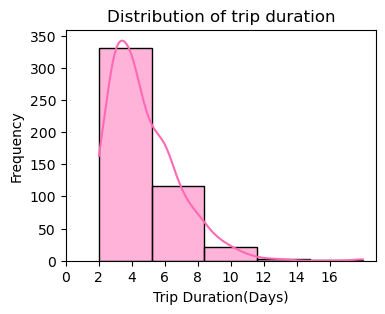

In [71]:
plt.figure(figsize=(4,3))
sns.histplot(df['Duration'],bins=5,kde=True,color='hotpink')
plt.title('Distribution of trip duration')
plt.xlabel('Trip Duration(Days)')
plt.ylabel('Frequency')
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.show()

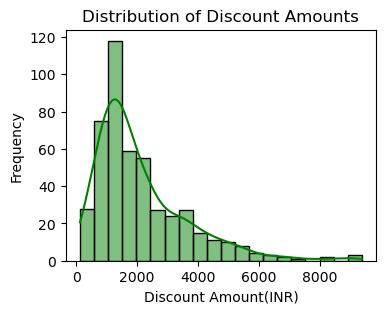

In [83]:
plt.figure(figsize=(4,3))
sns.histplot(df['Discount_Amount'],bins=20,kde=True,color='green')
plt.title('Distribution of Discount Amounts')
plt.xlabel('Discount Amount(INR)')
plt.ylabel('Frequency')
plt.show()

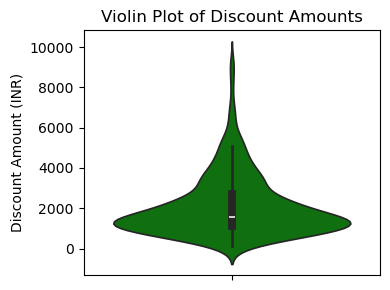

In [85]:
plt.figure(figsize=(4,3))
sns.violinplot(df["Discount_Amount"], color="green")
plt.title("Violin Plot of Discount Amounts")
plt.ylabel("Discount Amount (INR)")
plt.tight_layout()
plt.show()

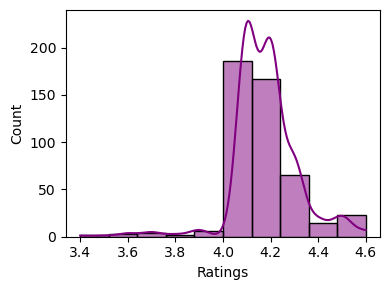

In [95]:
plt.figure(figsize=(4,3))
sns.histplot(df['Ratings'],bins=10,color='Purple',kde=True)
plt.tight_layout()
plt.show()

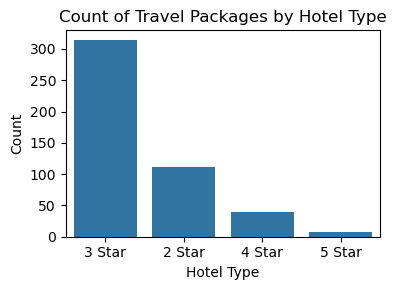

In [117]:
plt.figure(figsize=(4,3))
sns.countplot(x=df['Hotel_Types'],)
plt.title("Count of Travel Packages by Hotel Type")
plt.xlabel("Hotel Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

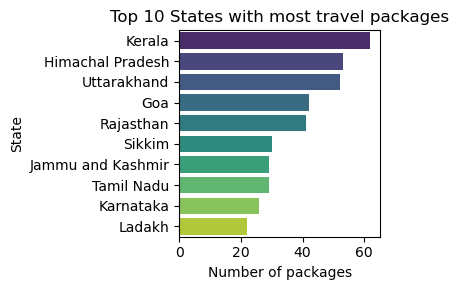

In [135]:
plt.figure(figsize=(4,3))
top_states=df['State'].value_counts().head(10)
sns.barplot(x=top_states.values,y=top_states.index,hue=top_states.index,palette='viridis')
plt.title('Top 10 States with most travel packages')
plt.xlabel('Number of packages')
plt.ylabel('State')
plt.tight_layout()
plt.show()

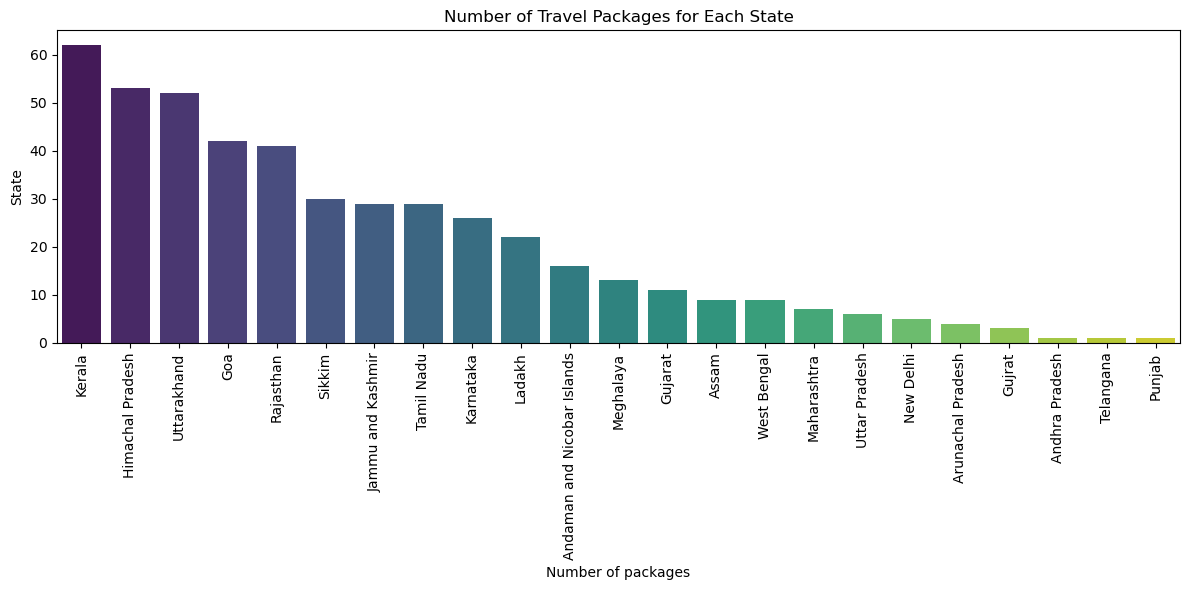

In [141]:
plt.figure(figsize=(12,6))
top_state=(df['State'].value_counts())
sns.barplot(x=top_state.index,y=top_state.values,hue=top_state.index,palette='viridis')
plt.title('Number of Travel Packages for Each State')
plt.xlabel('Number of packages')
plt.ylabel('State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

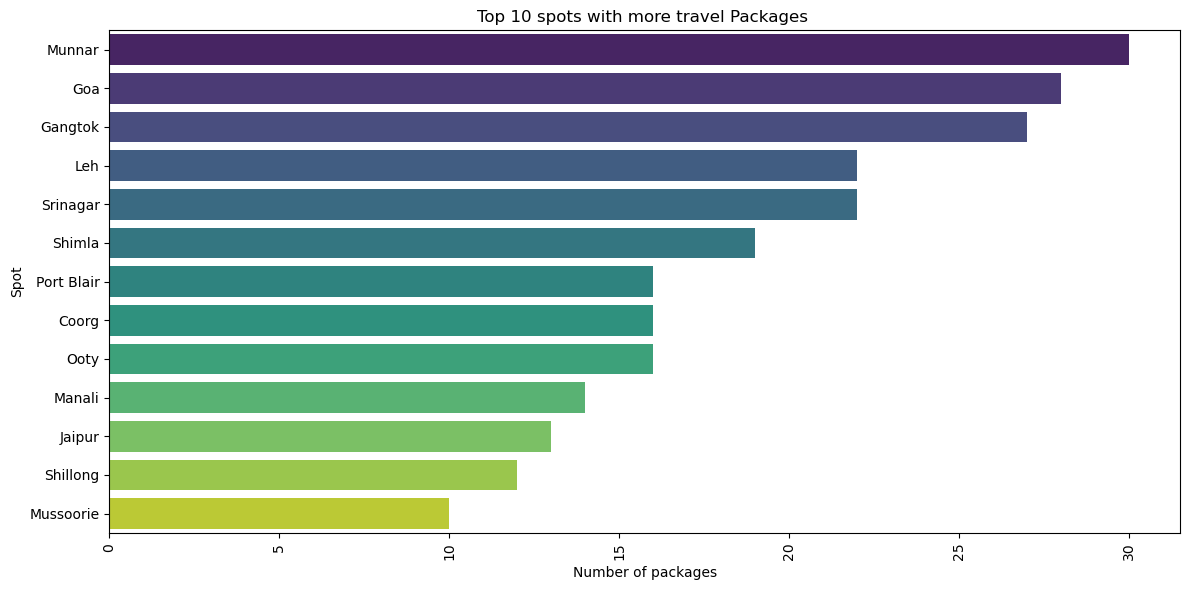

<Figure size 400x300 with 0 Axes>

In [151]:
plt.figure(figsize=(12,6))
top_city=(df['City_Names'].value_counts().head(13))
sns.barplot(y=top_city.index,x=top_city.values,hue=top_city.index,palette='viridis')
plt.title('Top 10 spots with more travel Packages ')
plt.xlabel('Number of packages')
plt.ylabel('Spot')
plt.xticks(rotation=90)
plt.tight_layout()
plt.figure(figsize=(4,3))
plt.show()

## Bivariate Analysis

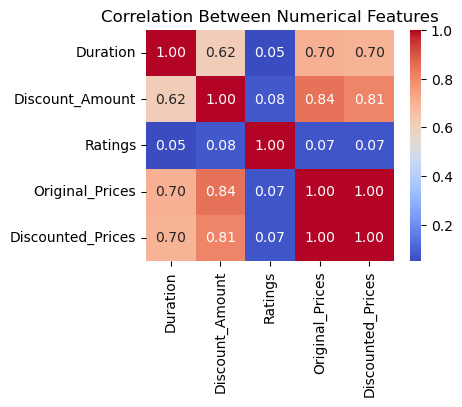

In [232]:
plt.figure(figsize=(4,3))
corrl=df[['Duration', 'Discount_Amount', 'Ratings', 'Original_Prices', 'Discounted_Prices']].corr()
sns.heatmap(corrl,annot=True,cmap='coolwarm',fmt='.2f')
plt.title("Correlation Between Numerical Features")
plt.savefig("corr.png", dpi=300, bbox_inches='tight') 
plt.show()

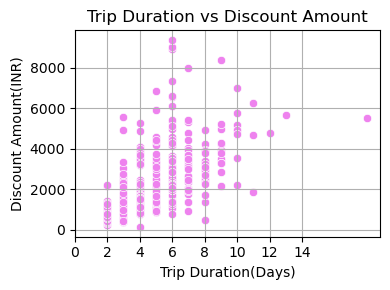

In [169]:
plt.figure(figsize=(4,3))
sns.scatterplot(x=df['Duration'],y=df['Discount_Amount'],color='violet')
plt.title("Trip Duration vs Discount Amount")
plt.xlabel('Trip Duration(Days)')
plt.ylabel('Discount Amount(INR)')
plt.xticks([0,2,4,6,8,10,12,14])
plt.tight_layout()
plt.grid()
plt.show()

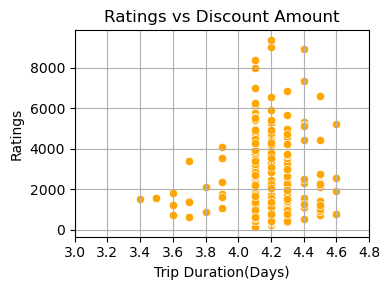

In [175]:
plt.figure(figsize=(4,3))
sns.scatterplot(x=df['Ratings'],y=df['Discount_Amount'],color='orange')
plt.title("Ratings vs Discount Amount")
plt.xlabel('Trip Duration(Days)')
plt.ylabel('Ratings')
plt.xticks([3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8])
plt.tight_layout()
plt.grid()
plt.show()

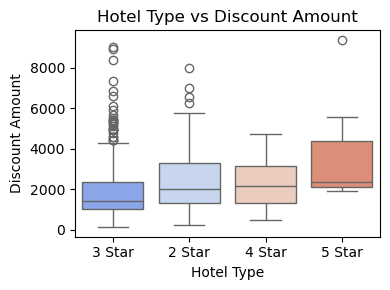

In [191]:
plt.figure(figsize=(4,3))
sns.boxplot(x=df['Hotel_Types'],y=df['Discount_Amount'],hue=df['Hotel_Types'],palette='coolwarm')
plt.tight_layout()
plt.xlabel('Hotel Type')
plt.ylabel('Discount Amount')
plt.title('Hotel Type vs Discount Amount')
plt.tight_layout()
plt.show()

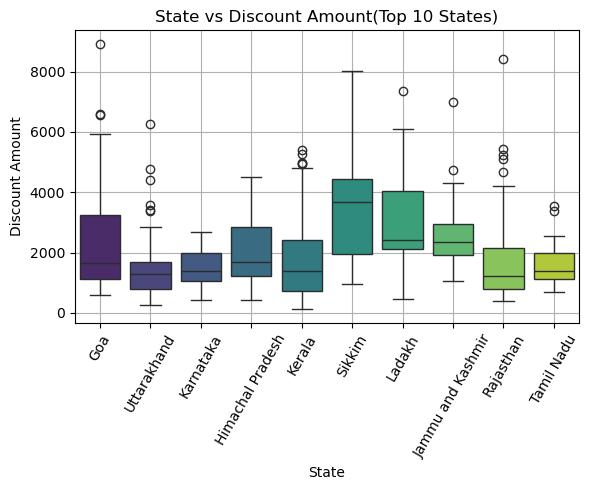

In [219]:
plt.figure(figsize=(6,5))
top_states_df = df[df["State"].isin(top_states.index)]
sns.boxplot(x=top_states_df['State'],y=df['Discount_Amount'],hue=top_states_df['State'],palette='viridis')
plt.tight_layout()
plt.xlabel('State')
plt.ylabel('Discount Amount')
plt.title('State vs Discount Amount(Top 10 States)')
plt.xticks(rotation=60)
plt.grid()
plt.tight_layout()
plt.show()